## Imports

The $AR(p)$ model is purely written with numpy.

In [99]:
import os

import numpy as np
from scipy import special

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm.notebook import tqdm

rng = np.random.default_rng(11)

### Create Surrogated Data

The surrogated dataset is only used to validate the functionality of the $AR(p)$ model. The dataset is created using itself an $AR(p=3)$ model with predefined coefficients $\phi_{1...3}$ The model should derive the right coefficients back from drawing statistical inferences from the dataset.

$\displaystyle AR(3)=\phi_1u_{t-1}+\phi_2u_{t-2}+\phi_3u_{t-3}+w_t$

In [100]:
def create_surrogated_data(n_data=2e+6):

    # Random start data
    data = [1, 0, -1]
    phis_test = [0.4, 0.2, 0.15]

    for _ in range(int(n_data)):

        white_noise = rng.standard_normal()
        result = sum([x * p for x, p in zip(reversed(data), phis_test)])
        result += white_noise
        data.append(result)
        
    return np.array(data)

surrogated_data = create_surrogated_data()

### Load Data

Loads the FINO1 wind velocity data.

In [101]:
DIRNAME = os.path.abspath("")
PLOTS_PATH = os.path.join(DIRNAME, "Plots")
DATA_DIR = os.path.join(os.path.dirname(DIRNAME), "FINO1Data")
ANI_PATH = os.path.join(PLOTS_PATH, "Animation")
ARRAY_PATH = os.path.join(DIRNAME, "Arrays")


os.makedirs(PLOTS_PATH, exist_ok=True)
os.makedirs(ANI_PATH, exist_ok=True)
os.makedirs(ARRAY_PATH, exist_ok=True)

datasets = {path.replace(".npy", ""): np.load(os.path.join(DATA_DIR, path), allow_pickle=True) for path in os.listdir(DATA_DIR) if path.endswith("npy")}

In [102]:
# Surrogated data is already stationary
datasets["surrogated data"] = surrogated_data

### 2D Histogram

In [103]:
# from copy import copy

# import numpy as np
# import numpy.matlib
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm

# fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')


# x = np.arange(d)
# y = np.array([datasets["2015-2017_100m"][d*i:d*i+d] for i in range(l-1)])


# axes[0].plot(x, y.T, color="C0", alpha=0.1)
# axes[0].set_title("Line plot with alpha")


# # Now we will convert the multiple time series into a histogram. Not only will
# # the hidden signal be more visible, but it is also a much quicker procedure.
# # Linearly interpolate between the points in each time series
# num_fine = 10000
# x_fine = np.linspace(x.min(), x.max(), num_fine)
# y_fine = np.empty((l-1, num_fine), dtype=float)
# for i in range(l-1):
#     y_fine[i, :] = np.interp(x_fine, x, y[i, :])
# y_fine = y_fine.flatten()
# x_fine = np.matlib.repmat(x_fine, l-1, 1).flatten()


# # Plot (x, y) points in 2d histogram with log colorscale
# # It is pretty evident that there is some kind of structure under the noise
# # You can tune vmax to make signal more visible
# cmap = copy(plt.cm.plasma)
# cmap.set_bad(cmap(0))
# h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])

# pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
#                          norm=LogNorm(vmax=1e3), rasterized=True)

# fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
# axes[1].set_title("2d histogram and log color scale")

# # Same data but on linear color scale
# pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
#                          vmax=1e3, rasterized=True)

# fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
# axes[2].set_title("2d histogram and linear color scale")

# plt.show()

### Outdated: Remove NaNs with Linear Interpolation

#### Lerp (linear interpolation)

Gets rid of the NaN's by connecting adjacent values with a linear interpolation.

In [8]:
# def lerp(data):
    
#     ok = ~np.isnan(data)
#     xp = ok.nonzero()[0]
#     fp = data[ok]
#     x = np.isnan(data).nonzero()[0]
#     data[~ok] = np.interp(x, xp, fp)

#     return data

In [9]:
# Removing NaNs with linear interpolation
# datasets = {key: lerp(value) for key, value in datasets.items()}

### Differentiation

The differentiation of the time series $v_t$ and $v_{t+1}$ leads to a time series of wind fluctuations $u_t$:

$\displaystyle u(t)=v(t+1)-v(t)$

In [104]:
# Differentiation to make data stationary
u_datasets = {key: dataset[1:] - dataset[:-1] for key, dataset in datasets.items()}

C:\Users\Maik\AppData\Local\Temp\ipykernel_7184\421177185.py:2: RuntimeWarning: invalid value encountered in subtract
  u_datasets = {key: dataset[1:] - dataset[:-1] for key, dataset in datasets.items()}


### Dataset

In [109]:
# Active dataset
dname = "2015-2017_100m"
dataset = u_datasets[dname]
dataset[dataset>5] = np.nan
dataset[dataset<-5] = np.nan

### Pre-Analysis

#### Sokus Plot

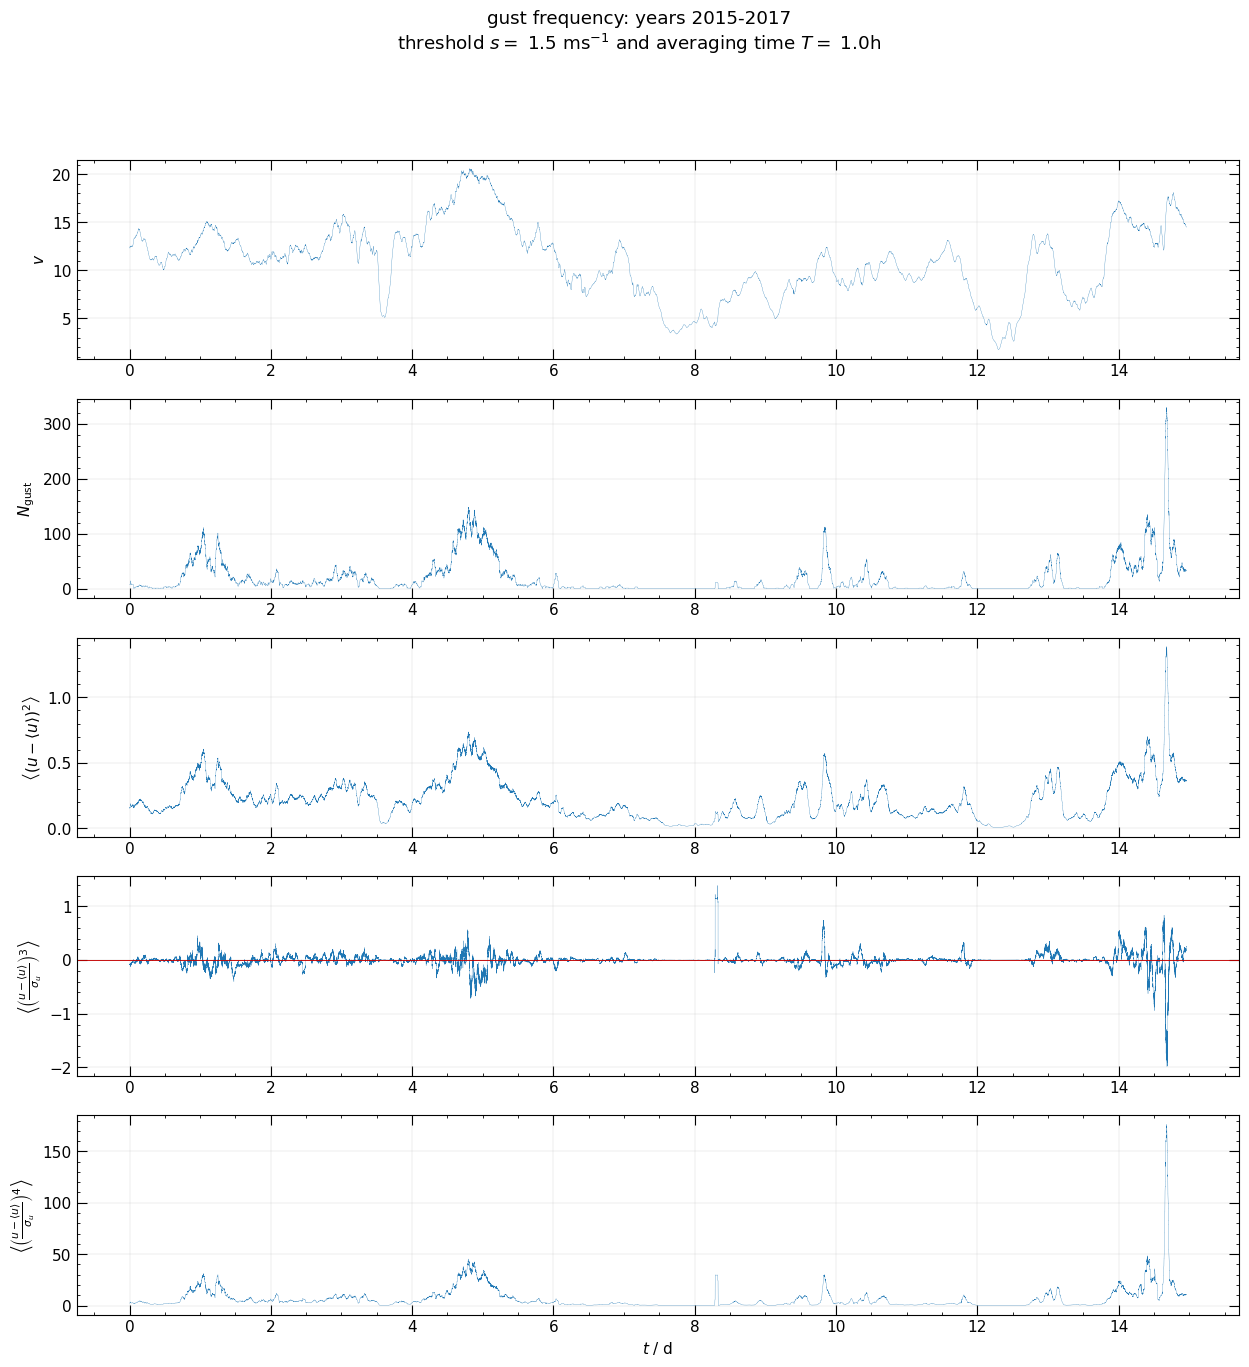

In [106]:
import time
# Berechne Häufigkeit von Böen (über die Zeit)

jahr            = '2015-2017'                                                           # zu analysierender Zeitraum
h               = ['100']                                                                  # Höhe h
# color           = ['b','g','r']
colors = sns.color_palette("rocket", 5)
colors = [None for i in range(5)]

threshold       = 1.5                                                                    # das threshold-fache der Standardabweichung gilt als Böe: Schwellwert
timeres         = 1                                                                     # zeitliche Auflösung der Daten in Sekunden
tau             = 60*60                                                                 # Mittelungszeitraum

dvsectionstart  = 0*24*60*60 
dvsectionlength = 15*24*60*60#5*24*60*60d

latexplot       = False

def LagDiff(data, dt=1):
    dt   = int(dt)
    lena = len(data)
    leni = int(lena-dt)
    dif  = np.zeros(leni)
    dif  = data[0:leni] - data[dt:(leni+dt)]
    return dif

def MA(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def nanMA(x, N):   # FUNKTIONIERT!!! :)
    length      = len(x)#
    ret         = np.zeros(length - N + 1)
    oldx        = x[0]
    thisn       = np.count_nonzero(~np.isnan(x[0:N]))
    oldsum      = np.nansum(x[0:N])
    ret[0]      = oldsum/thisn
    for t in np.arange(1, len(ret)):
        xend        = x[t+N-1]
        oldx        = x[t-1]
        if np.isnan(xend):
            thisn       = thisn - 1
            xend        = 0
        if np.isnan(oldx):
            thisn       = thisn + 1
            oldx        = 0
        if (thisn == 0):
            thissum     = 0
            ret[t]      = np.nan
        else:
            thissum     = oldsum - oldx + xend#
            ret[t]      = thissum/thisn
        oldsum      = thissum
    return ret

if latexplot:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(15,15))

for i in range(len(h)):

    v               = datasets[dname]
    dv              = -LagDiff(data=dataset, dt=1)            # negativ, weil dv = v[t+τ] - v[t]
    dv              = dv[dvsectionstart:(dvsectionstart+dvsectionlength)]
    v               = v[dvsectionstart:(dvsectionstart+dvsectionlength)]

    isgust          = np.zeros(len(dv), dtype=bool)
    idx             = np.where(dv >= threshold)
    isgust[idx]     = True

    thislabel       = h[i] + "m"
    v               = nanMA(x=v, N=tau)
    tag             = np.arange(0, len(v))/(24*60*60)
    ax1.plot(tag, v, linewidth=0.2, label=thislabel, color=colors[0])
    
    isgust          = 1*isgust    
    ngusts          = MA(x=isgust, N=tau)
    ngusts          = ngusts*tau
    tag             = np.arange(0, len(ngusts))/(24*60*60)
    ax2.plot(tag, ngusts, linewidth=0.2, label=thislabel, color=colors[1])

    dvnorm          = -(dv - np.nanmean(dv))
    dvvar           = np.power(dvnorm, 2)
    dvvar           = nanMA(x=dvvar, N=tau)
    ax3.plot(tag, dvvar, linewidth=0.2, label=thislabel, color=colors[2])

    dvnorm          = dvnorm/np.nanstd(dvnorm)
    dvskew          = np.power(dvnorm, 3)
    dvskewmean      = np.nanmean(dvskew)
    dvskew          = nanMA(x=dvskew, N=tau)
    ax4.plot(tag, dvskew, linewidth=0.2, label=thislabel, color=colors[3])
    ax4.axhline(y=0, xmin=np.min(tag), xmax=20*np.max(tag), c="black", linewidth=0.5)
    ax4.axhline(y=dvskewmean, xmin=np.min(tag), xmax=20*np.max(tag), c="red", linewidth=0.5, label="globale Schiefe im Abschnitt")

    dvkurt          = np.power(dvnorm, 4)
    dvkurt          = nanMA(x=dvkurt, N=tau)
    ax5.plot(tag, dvkurt, linewidth=0.2, label=thislabel, color=colors[4])

ax1.set_ylabel(r'$v$')
ax2.set_ylabel(r'$N_{\mathrm{gust}}$')  
ax3.set_ylabel(r'$\left\langle (u - \langle u \rangle)^2 \right\rangle$')
ax4.set_ylabel(r'$\left\langle \left(\frac{u - \langle u \rangle}{\sigma_u}\right)^3 \right\rangle$')
ax5.set_ylabel(r'$\left\langle \left(\frac{u - \langle u \rangle}{\sigma_u}\right)^4 \right\rangle$')
ax5.set_xlabel(r'$t$ / d')



for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.grid(linewidth=0.2, alpha=0.8)

    ax.minorticks_on()
    ax.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
    ax.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)




mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
tage            = tau/(24*60*60)
stunden         = tau/(60*60)
plt.suptitle('gust frequency: years ' + jahr + '\n' + r'threshold $s=$ ' + str(threshold) + r' ms$^{-1}$ and averaging time $T=$ ' + str(np.round(stunden)) + 'h')
plt.show()


#### Probability Densities

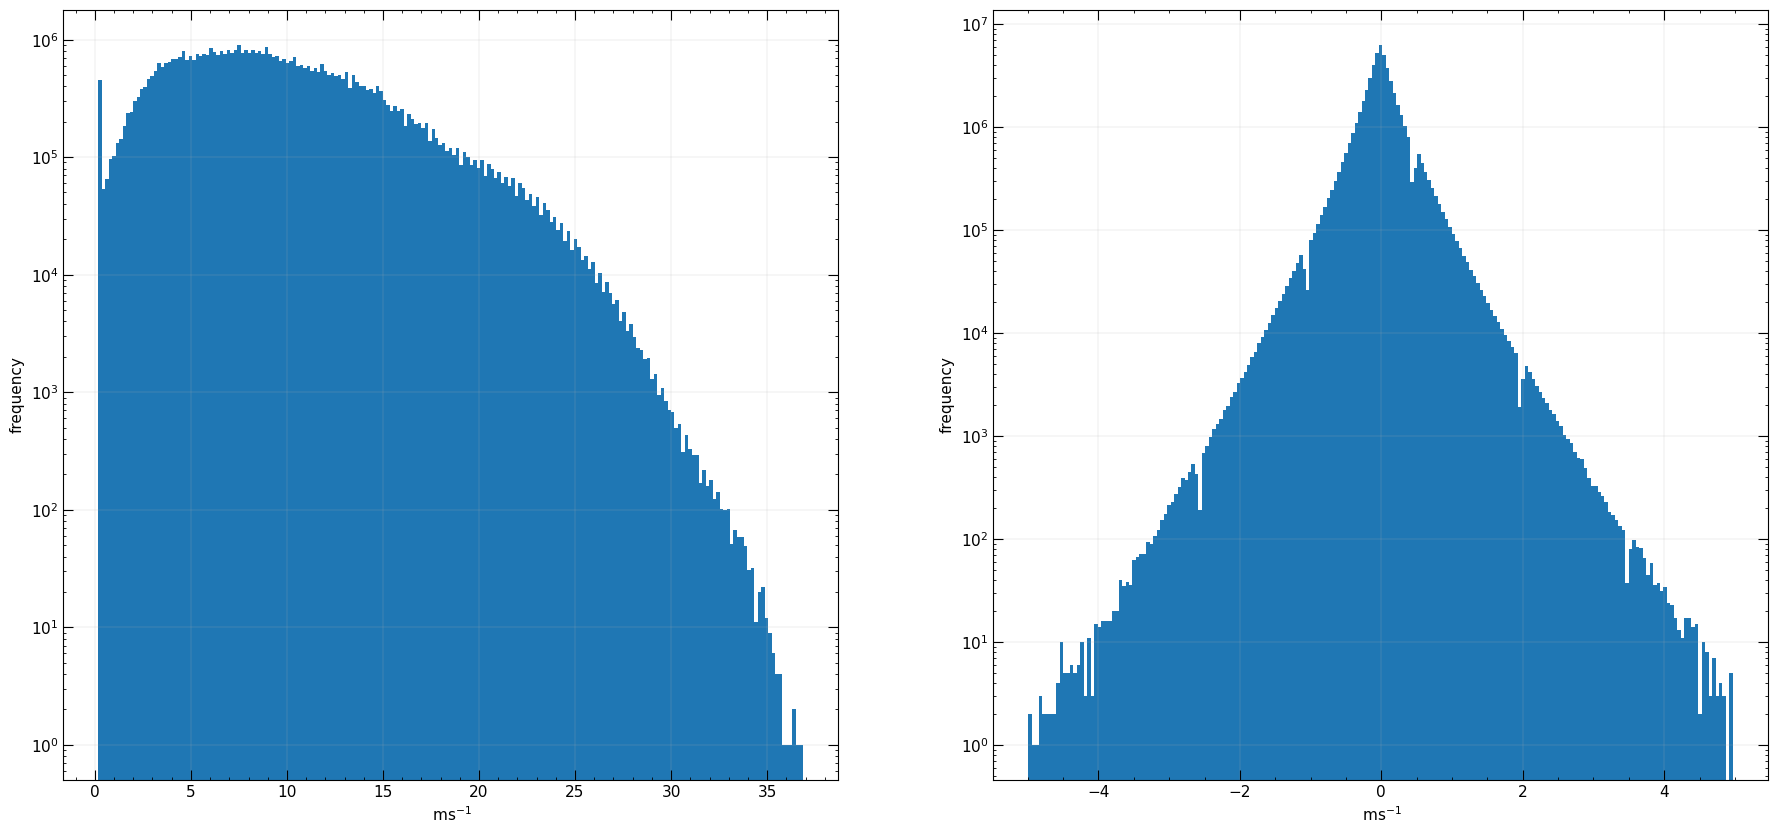

In [138]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

data = [datasets[dname], dataset]

for i, ax in enumerate([ax1, ax2]):
    ax.hist(data[i], bins=203)
    ax.set_yscale("log")

    ax.grid(linewidth=0.2, alpha=0.8)

    ax.minorticks_on()
    ax.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
    ax.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
    ax.set_xlabel(r' ms$^{-1}$')
    ax.set_ylabel("frequency")

plt.savefig(os.path.join(PLOTS_PATH, f"Histogramm_uv_dname={dname}.png"), format="png", dpi=300, bbox_inches="tight")

#### Plotting NaNs

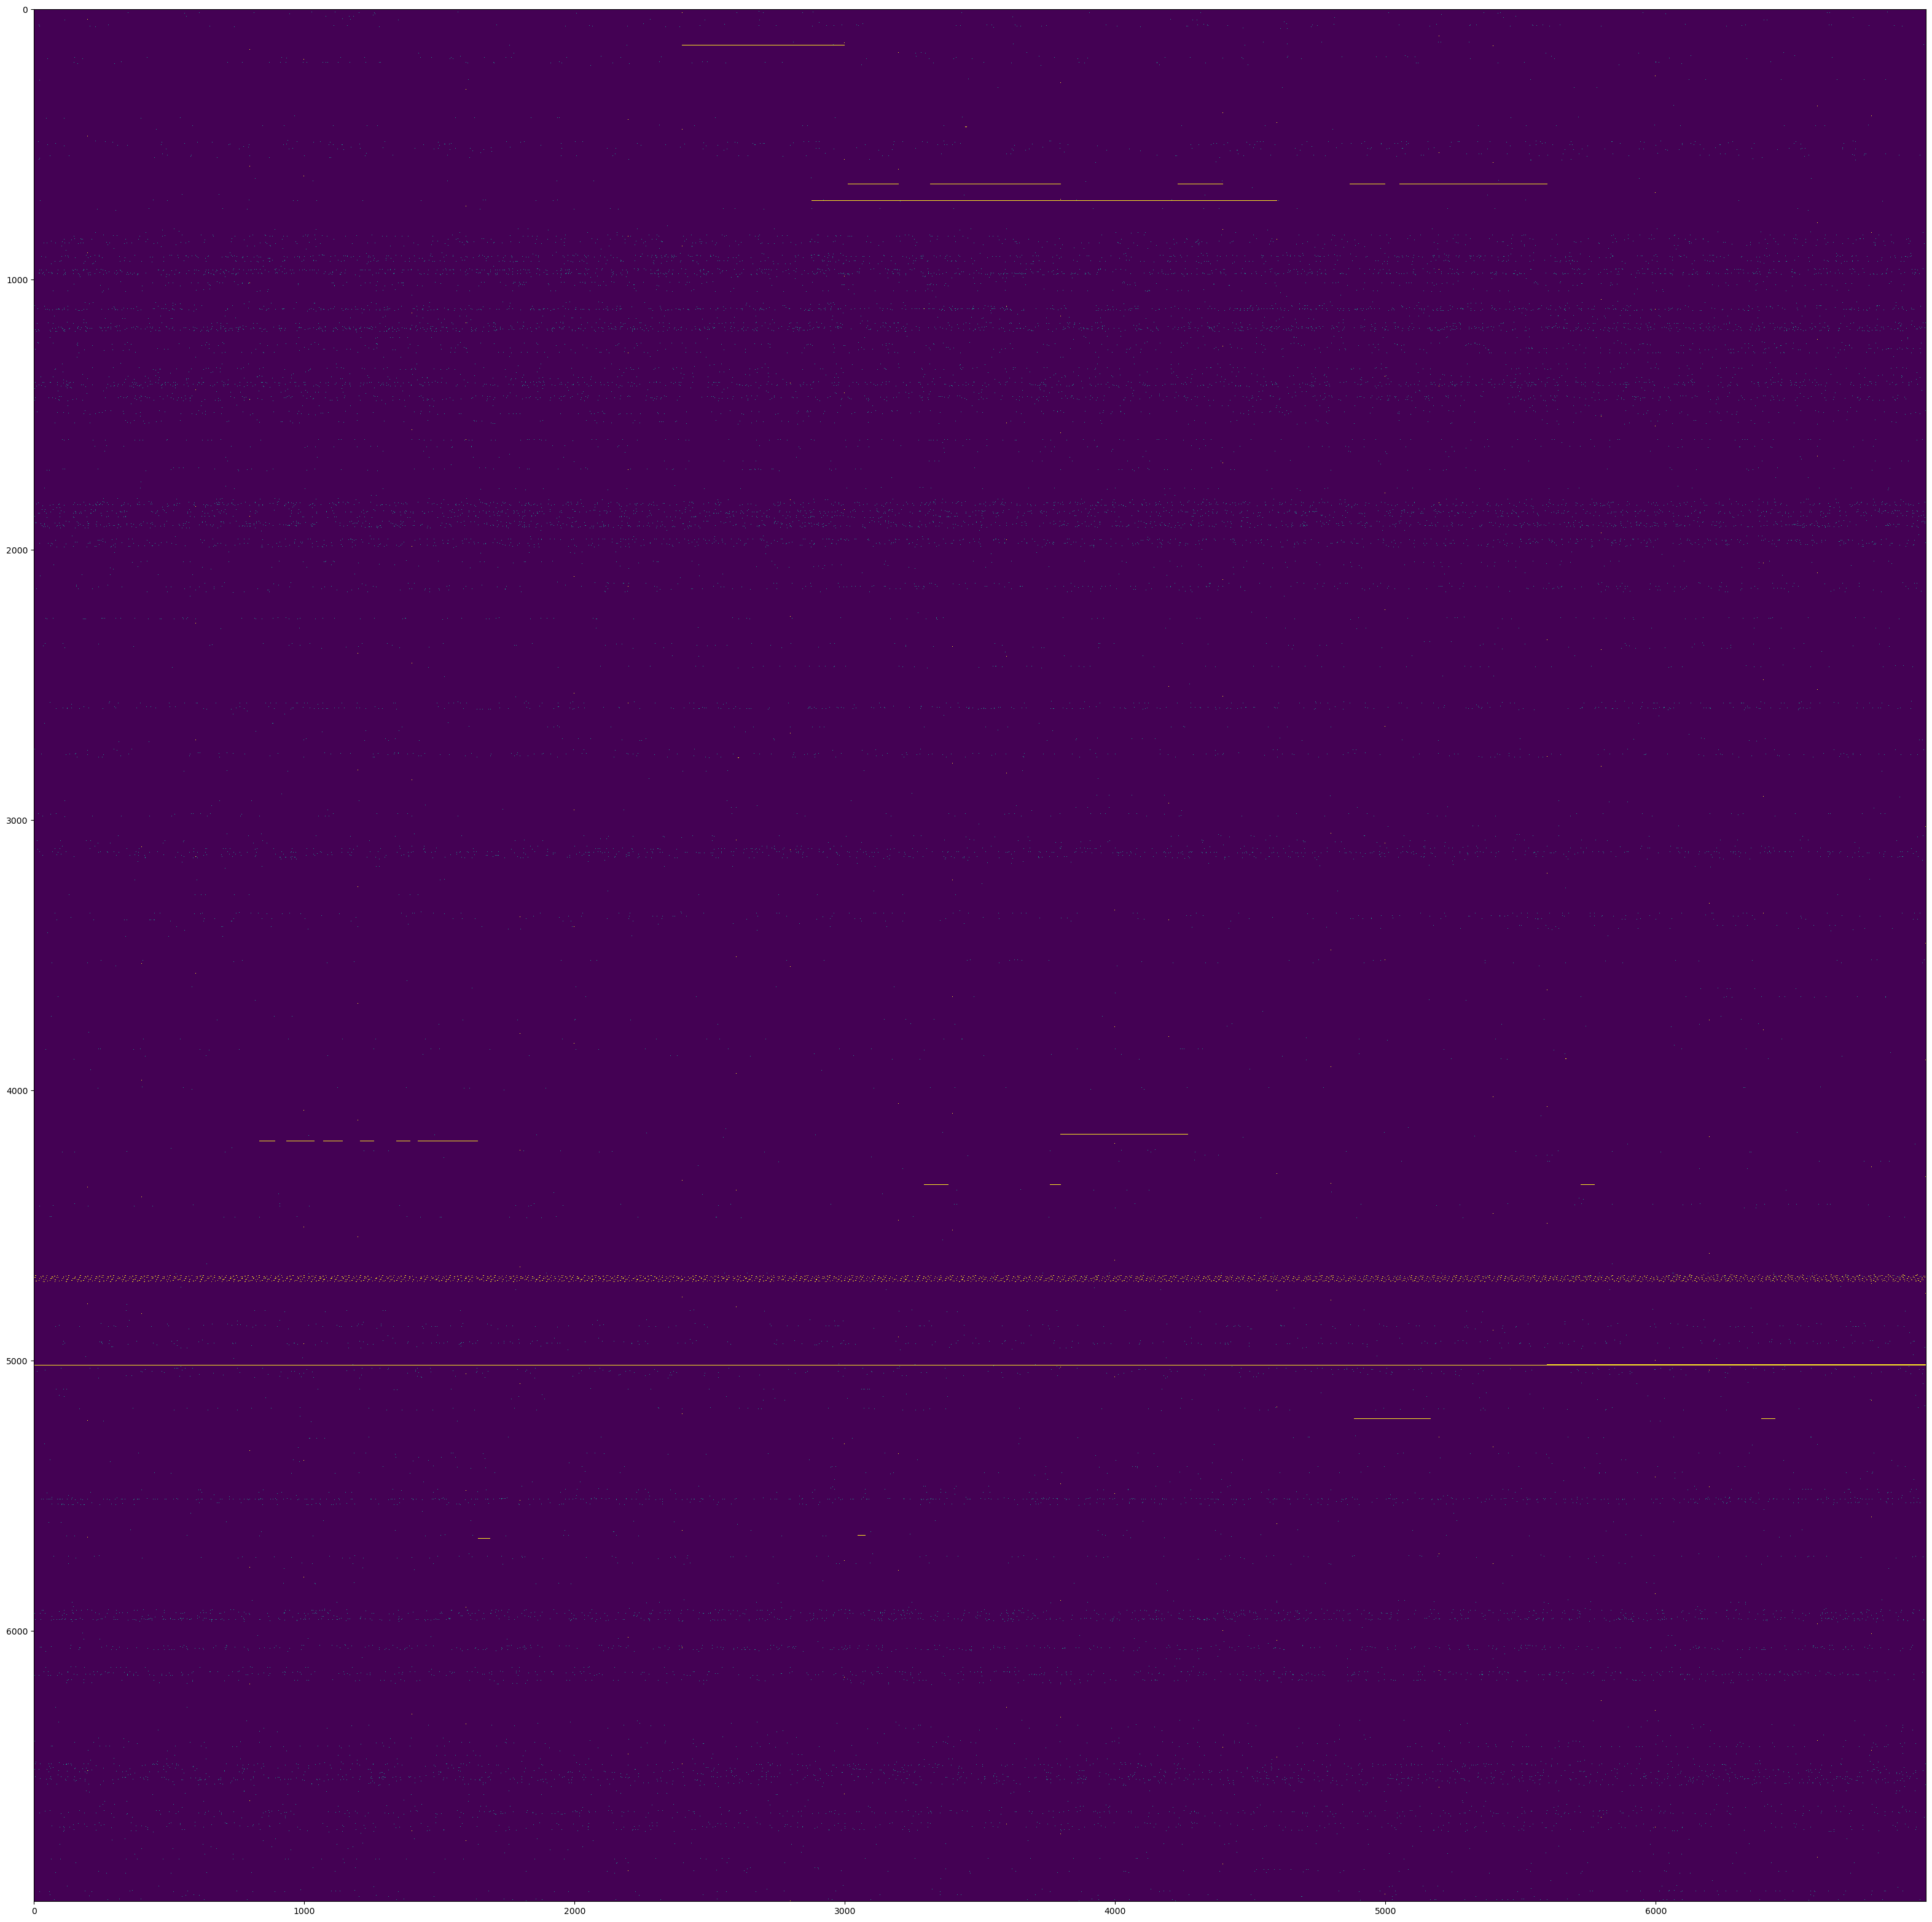

In [16]:
_ = plt.figure(figsize=(40,40))
nans = np.isnan(dataset)[:49000000].reshape(7000, 7000)
gusts = ((dataset>1.6)[:49000000]*0.5).reshape(7000,7000)
plt.imshow(nans + gusts, interpolation="nearest")

### Simple Moving Average

$\displaystyle SMA=\frac{1}{k}\sum_{i=t-k+1}^tu_i$

$\displaystyle {SMA}_{k, next} = SMA_{k, prev} + \frac{1}{k}\left(u_{t+1}-u_{t-k+1}\right)$ but we are using convolutions instead

In [14]:
def get_sma(data, q=3):
 
    ok = ~np.isnan(data)
    data[~ok] = .0
    denominators = np.convolve(ok, np.ones(q), "valid")
    denominators[~(denominators>0)] += 1

    sma = np.convolve(data, np.ones(q), "valid")
    sma /= denominators

    return sma

sma = get_sma(np.array([1,2,3,np.nan, np.nan, np.nan, np.nan, 4, 5]))


#_ = plt.figure(figsize=(15,5))
#plt.plot(np.isnan(dataset)[:10000000])

indices = 2
max_length = 100
surrogated_data[:10000]
train_per = 5

nans = np.isnan(surrogated_data)

#nanMA([1,2,3,4,3,2,3,2,np.nan,3,np.nan], 3)

## $AR(p)$

In [17]:
def get_rolling(data, train_per, mode, show):

    indices = np.arange(0, len(data)-train_per+1)
    splits = int(len(data) / 20000)+1
    indices_split = np.array_split(indices, splits)

    rolling = []

    for indices in tqdm(indices_split, disable=not(show)):
        indices = indices[:, None] + np.arange(train_per)
        x = data[indices]

        if mode == "std":
            split_rolling = np.nanstd(x, axis=1)
        elif mode == "mean":
            split_rolling = np.nanmean(x, axis=1)
            
        rolling.append(split_rolling)
        
    return np.concatenate(rolling)


### Yule-Walker Equation

#### Autocovariance

The autocovariance is the covariance of a time series with itself and with another time point with itself $x_t$ and $x_{t+\tau}$. Here, $\tau$ is the lag.

$\displaystyle Cov({u_t,u_{t+\tau}})=(u_t-\mu_x)(u_{t+\tau}-\mu_x)$

#### Autocorrelation function

Hereby $\gamma_x(\tau)$ is the autocovariance of every point with lag $\tau$.

$\displaystyle \rho(t_1,t_2)=\rho(\tau)=\frac{\gamma(\tau)}{\gamma(0)}$

In [59]:
def get_phis(data, p, train_per):
    
    # TODO Implement substract mean

    z = [np.array(data[lag:] * data[:len(data)-lag])[:len(data)-p] for lag in range(0, p+1)]

    mean_gamma = [get_rolling(z[lag], train_per, mode="mean", show=False) for lag in range(1, p+1)]
    acfs = [gamma / mean_gamma[0] for gamma in mean_gamma]

    acfs.insert(0, np.ones_like(acfs[0]))
    acfs = np.stack(acfs)
    
    matrix_mask = np.array([abs(-k+j) for k in range(p) for j in range(p)])
    matrices = acfs[matrix_mask, :].reshape(p,p,-1).T
    
    det_mask = np.linalg.det(matrices)
    matrices[det_mask==0] += np.eye(p) * 1e-4
    phis = np.linalg.solve(matrices, acfs[1:].T)

    return np.array(phis), np.array(mean_gamma)

### Model Configuration

In [60]:
train_per = 20
gust_th = 1.5
p = 2
beta = 1
gust_th_gauss = gust_th ** beta
dataset_gauss = np.sign(dataset) * np.abs(dataset)**beta


In [61]:
phis, mean_gamma = get_phis(dataset_gauss, p=p, train_per=train_per)

C:\Users\Maik\AppData\Local\Temp\ipykernel_7184\2595372854.py:16: RuntimeWarning: Mean of empty slice
  split_rolling = np.nanmean(x, axis=1)
C:\Users\Maik\AppData\Local\Temp\ipykernel_7184\4027337530.py:8: RuntimeWarning: invalid value encountered in divide
  acfs = [gamma / mean_gamma[0] for gamma in mean_gamma]
C:\Users\Maik\AppData\Local\Temp\ipykernel_7184\4027337530.py:8: RuntimeWarning: divide by zero encountered in divide
  acfs = [gamma / mean_gamma[0] for gamma in mean_gamma]


### Forecast

$AR(p) = \phi_1x_{t-1}+\phi_2x_{t-2}+\phi_3x_{t-3}+{\color{yellow}{w(t)}}$

$w(t) \sim \mathcal{N}(\mu=0, \sigma_w^2)$

In [54]:
var_w = mean_gamma[0] - (phis * mean_gamma[1:].T).sum(axis=1)
var_w[var_w<0] = 0.001
white_noise = rng.normal(scale=var_w[p:-1])

In [55]:
indices = np.arange(train_per-1, len(dataset_gauss))[:, None] - np.arange(p)
x = dataset_gauss[indices]

res = x[p:-1] * phis
res = res.sum(axis=1)
res += white_noise

ValueError: operands could not be broadcast together with shapes (52531177,2) (52531178,2) 

The probability density $p_u$ of $u_t$ is a stretched-exponential-distribution.

### Probability Thresholds

$\displaystyle P\left(\hat{u}(t)> u_x\right)=\frac{1}{2}\left[1-\operatorname{erf}\left(\frac{u_x-\hat{u}(t)}{\sqrt{2\sigma_w^2(t)}}\right)\right]$

In [ ]:
z = (gust_th_gauss - res) / ((2*stds[p:-1]**2)**0.5)
pred_integral = 0.5 * (1 - special.erf(z))

## ROC-Curves

$P\left(\hat{u}(t) > u_x\right)$


In [ ]:
wind_nans = np.isnan(dataset[train_per+p:])
wind_gusts = np.where(dataset[train_per+p:] >= gust_th, 3, 0)

n_gusts = np.where(dataset[train_per+p:] >= gust_th, 1, 0).sum()

$\displaystyle G(t) = \begin{cases} 3 & u(t) > u_x \\ 1 & u(t) < u_x \end{cases}$

In [ ]:
lowest_prob     = 10**(-9)      # lowest  probability threshold
highest_prob    = 1             # highest probability threshold
probs_perDecade = 10            # Number of probability threshold values in every decade
prob_thresholds  = 10**np.arange(-9, 1 + 1/10, 1/10)
prob_thresholds  = np.append([0], prob_thresholds)

performances2 = dict.fromkeys(prob_thresholds)


for quantile in tqdm(prob_thresholds):

    wind_gusts_pred = np.where(pred_integral >= quantile, 1, 0) 

    true_positive = np.where(wind_gusts_pred + wind_gusts == 4, 1, 0)
    false_positive = np.where(wind_gusts_pred + wind_gusts == 1, 1, 0)

    true_positive_rate = true_positive.sum() / n_gusts
    false_positive_rate = false_positive[~wind_nans].sum() / (len(wind_gusts) - n_gusts - wind_nans.sum())

    performances2[quantile] = (true_positive_rate, false_positive_rate)


  0%|          | 0/102 [00:00<?, ?it/s]

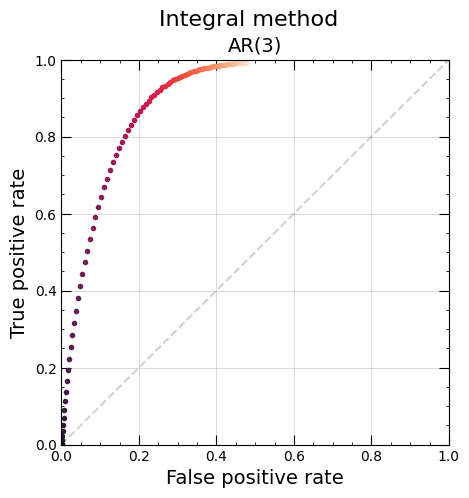

In [ ]:
colors = sns.color_palette("rocket_r", len(performances2))

fig = plt.figure(1, figsize=(5,5))

i = 0
for threshold, (true_positive_rate, false_positive_rate) in performances2.items():
    plt.plot(false_positive_rate, true_positive_rate, "o", color=colors[i], markersize=3)
    i += 1
plt.plot(np.arange(2), linestyle="--", color='#0f0f0f30')


plt.grid(linewidth=0.4, alpha=0.8)
plt.xlim(0,1)
plt.ylim(0,1)

plt.minorticks_on()
plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
plt.xlabel("False positive rate", fontsize=14)
plt.ylabel("True positive rate", fontsize=14)

plt.title(f"AR({p})", fontsize=14)
plt.suptitle("Integral method", fontsize=16)
#plt.legend(title="Exceeding probability", fontsize=10, bbox_to_anchor=(1.02,1.1))

plt.savefig(os.path.join(PLOTS_PATH, f"{dname}-tau={train_per}Integral-AR({p})mode=superfast.png"), format="png", dpi=300, bbox_inches="tight")

### Calculating the best $\mathcal{Q}_{\tau}(t)$ using $\Xi$

In [ ]:
base_1 = np.array([.5,-.5])
base_2 = np.array([.5, .5])

points = dict()

for key, (y,x) in performances2.items():
    point = x * base_1 + y * base_2
    points[key] = point


NameError: name 'performances2' is not defined

In [ ]:
key = sorted(points.items(), key=lambda item:item[1][1])[-1][0]
xi = np.array([[x,y] for key, (x,y) in points.items()])

print(f"Key:                {key}")
print(f"Coordinates:        {performances2[key]}")
print(f"Xi max:             {np.max(xi[:, 1]):.3f}")

#dict(reversed(sorted(points.items(), key=lambda item:item[1][1])))

IndexError: list index out of range

## Post-Analysis

### Plotting Forecast

Text(0.5, 1.0, 'Model phis')

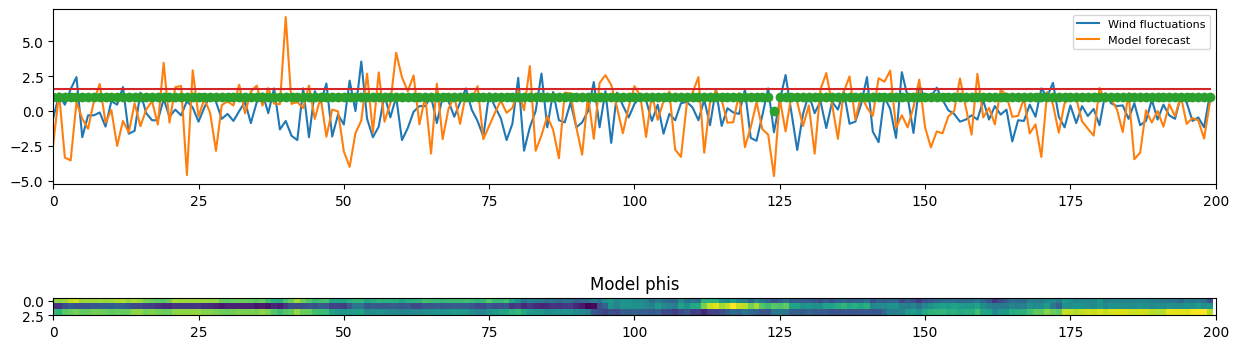

In [ ]:
window = 200
n = 6749828 - window

_, (ax1,ax2) = plt.subplots(2,1, figsize=(15,5))

ax1.plot(dataset[n+train_per:n+window+train_per], label="Wind fluctuations")
ax1.plot(res[n:n+window], label="Model forecast")
ax1.plot(wind_gusts_pred[n:n+window], "o")
ax1.set_xlim(0,window)
ax1.legend(fontsize=8)
ax1.plot(np.ones(window)*1.6)

ax2.imshow(phis[n:n+window].T)
ax2.set_xlim(0,window)
ax2.set_title("Model phis")

# plt.savefig(os.path.join(PLOTS_PATH, "ForecastAndPhis.png"), format="png", dpi=300, bbox_inches="tight")

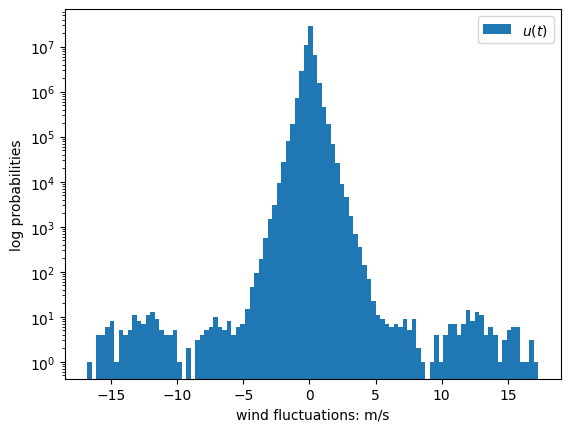

In [ ]:
# res1 = np.where(res < -20, -20, res)
# res1 = np.where(res1 > 20, 20, res1)
plt.hist(dataset_gauss[train_per-1:-p], bins=100, label="$u(t)$")
#plt.hist(res, bins=100, alpha=0.8, label="$\hat{u}(t)$")
plt.xlim()
plt.xlabel("wind fluctuations: m/s")
plt.ylabel("log probabilities")
plt.yscale("log")
plt.legend()
plt.savefig(os.path.join(PLOTS_PATH, "DistributionWind.png"), format="png")

### Plotting Phis

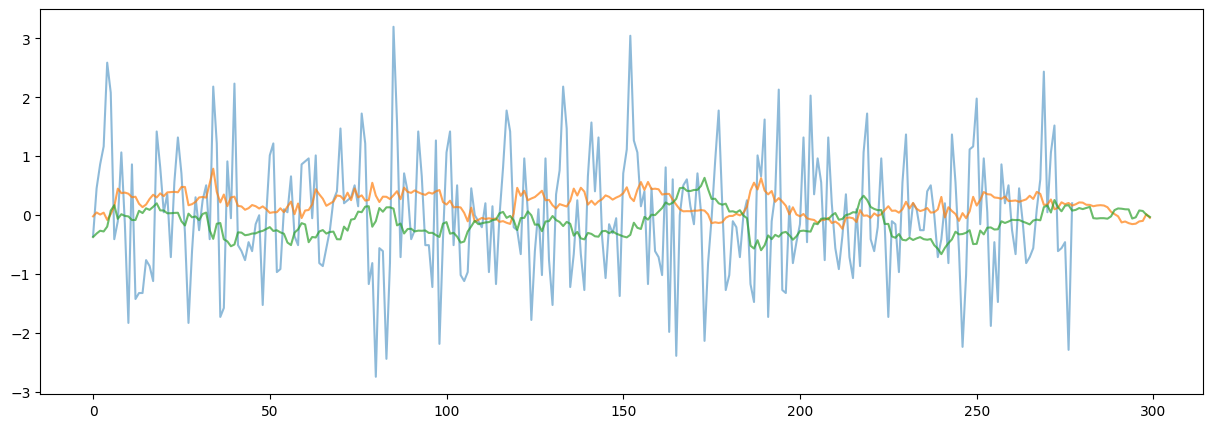

In [ ]:
_ = plt.figure(figsize=(15,5))
window = 300
n = 7750000
plt.plot(dataset[train_per+p +n: n+window], alpha=0.5)
plt.plot(phis[ n: n+window], alpha=0.7)


## Animation

In [ ]:
n = 11100000
x1 = dataset[n+train_per:n+200+train_per]
res1 = res[n:n+200]

t = np.arange(200)


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,5))

line1 = ax1.plot(x1[0], label="Wind fluctuations $u(t)$")[0]
line2 = ax1.plot(res1[0], label="Model predictions $\hat{u}(t)$")[0]
ax1.set(xlim=[0,200], ylim=[-3,3])
ax1.legend(fontsize=10)

ax2.set(xlim=[0,200])



def update(frame):

    line1.set_xdata(t[:frame-1])
    line1.set_ydata(x1[:frame-1])
    line2.set_xdata(t[:frame])
    line2.set_ydata(res1[:frame])
    ax2.imshow(phis[:frame].T)

    
    return (line1, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=200, interval=200)
ani.save(filename=os.path.join(ANI_PATH, f"{dname}_window={n}.gif"), writer="pillow")

plt.close()

## DNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [ ]:
class DenseModel(nn.Module):

    def __init__(self, n_hidden):
        
        super(DenseModel).__init__()

        self.dense_1 = nn.Linear()
        self.dense_2 = nn.Linear()

    def forward(self, x):

        x = F.relu(self.dense_1(x))
        x = F.relu(self.dense_2(x))
        
        return x

In [ ]:
denseModel = DenseModel()

TypeError: DenseModel.__init__() missing 1 required positional argument: 'n_hidden'

In [ ]:
dataset_test = dataset[:10000000]
dataset_train = dataset[10000000:]

In [ ]:
class DataLoader():
    